Plan is to create ASCII like art, using the benefits that a typewriter offers, but being aware of it's limitations. Namely, we can overlay characters to multiply the # of glyphs But, we have limited options to begin with, ie. no |@#

Process:
- Input image, desired output size, and directory of glyph images
    - Sub-division of letter spaces, as well as # glyphs per space
- Image is converted to greyscale, and scaled to output size
- Preprocess glyphs, making greyscale & scaled to sub-division
    - I THINK that scaling to eg 3x3 would be the same as doing manual averages
        - !Want to check this!
        - Current theory is this is what BOX resampling would achieve for us
    - If >1 glyph per space, calculate composite glyphs (This scales scarily)
- From the image, take blocks of pixels, the 'target'
    - Iterate through all the glyphs, working out 'distance' from target
        - Don't forget the black space 'glyph'
        - Distance metric likely to be N dimensional pythagorean distance (RMS)
    - Closest glyph gets chosen, repeat for all targets
- Render preview of design, using the original glyph images
    - Monospace REALLY helps with this (25 x 48)
- Produce instruction set to replicate on the typewriter
    - Developing a nice notation here will be useful to do

CURRENT PROBLEMS

- Currently treating glyphs as if they were square, need to adjust this so that the image doesn't end up being stretched vertically
    - Could treat the glyphs (25x48) as 1x2 in scale
    - This is a good approximation, but would be hardcoded
    - One option would just be to prestretch the image the other way

- Currently we're scaling image to full range of our glyphs.
    - This fixes the issues related to have thin glyphs on small SUB_LEVEL values
    - However, for higher SUB_LEVEL, we can end up making the image darker?



In [2]:
import os
from PIL import Image
from PIL import ImageChops
import numpy as np

GLYPH_DIR = 'E:/Users/Richard/Documents/One off mini projects/Typewriting/Typearter/Glyphs'
SUB_LEVEL = 3  # 3x3 taken from the source glyph
TARGET_WIDTH = 60

def fill_range(image, range_):
    # Scales image colors to fill range_
    # May not be fully warrented hard to say
    min_, max_ = image.getextrema()
    t_min, t_max = range_
    image =  image.point(lambda val: ((val-min_) * (t_max/max_))+ t_min)
    return image

def mean_square_distance(candidate, target):
    # calculates mean Square distance from 2 sequences
    assert len(candidate) == len(target)  # sanity
    squares = [(cand-targ)**2 for cand, targ in zip(candidate, target)]
    return np.mean(squares)

class glyph:
    def __init__(self, filename):
        self.filename = filename
        self.name = filename[:-4]
        self.image = Image.open(os.path.join(GLYPH_DIR, filename))
        self.fingerprint = self.image.convert("L")\
        .resize((SUB_LEVEL, SUB_LEVEL), Image.BOX)
        self.fingerdisplay = self.fingerprint.resize((25,48))
    def __str__(self):
        return self.name
    def __repr__(self):
        return 'glyph({})'.format(self.filename)

class combination_glyph:
    def __init__(glyph1, glyph2):
        # takes two glyphs, and combines into a 'combination glyph'
        # This is representative of overstriking the two glyphs
        self.glyph1 = glyph1
        self.glyph2 = glyph2
        self.image = ImageChops.darker(glyph1, glyph2)
        self.fingerprint = self.image.convert("L")\
        .resize((SUB_LEVEL, SUB_LEVEL), Image.BOX)
        self.fingerdisplay = self.fingerprint.resize((25,48))
    def __str__(self):
        return '{}&{}'.format(self.glyph1.name, self.glyph2.name)
    def __repr__(self):
        return 'combination_glyph({}, {})'.format(self.glyph1.filename, self.glyph2.filename)

def chunk():
    # Given an list of lists, a chunk width, and chunk height
    # Will return a list of 'chunks'
    # 0 1 2 3
    # 4 5 6 7
    # 8 9 A B
    # C D E F
    # Would chunk to:
    # [[0,1,4,5], [2,3,6,7], [8,9,C,D], [A,B,E,F]]
    pass
    
glyphs = {}
darkest_value = 255
lightest_value = 0
for filename in os.listdir(GLYPH_DIR):
    if filename.endswith(".png"):
        glyph_ = glyph(filename)
        glyphs.update({glyph_.name: glyph_})
        dark, light = glyph_.fingerprint.getextrema()
        darkest_value = min(dark, darkest_value)
        lightest_value = max(light, lightest_value)      
    
TARGET_IMAGE = 'E:/Users/Richard/Documents/One off mini projects/Typewriting/Typearter/fatdog2.png'
dog = Image.open(TARGET_IMAGE)
#dog.show()
smol_dog = dog.resize((TARGET_WIDTH * SUB_LEVEL, TARGET_WIDTH * SUB_LEVEL))
smol_dog = smol_dog.convert("L")
smol_dog = fill_range(smol_dog, (darkest_value, lightest_value))

target = np.asarray(smol_dog)
target_parts = []
for y in range(0, TARGET_WIDTH):
    for x in range(0, TARGET_WIDTH):
        data = target[np.ix_(range(x*SUB_LEVEL, (x+1)*SUB_LEVEL),range(y*SUB_LEVEL, (y+1)*SUB_LEVEL))]
        target_parts.append(data.flatten().tolist())
        
blank = Image.new("L", (SUB_LEVEL, SUB_LEVEL), 255)        
imarray = np.random.rand(SUB_LEVEL,SUB_LEVEL) * 255
rand_im = Image.fromarray(imarray.astype('uint8')).convert('L')
rand_im.getdata()
#rand_im.resize((25,48)).show()

result = []

for section in target_parts:
    best = None
    best_distance = float('inf')
    for glyph_name, glyph_ in glyphs.items():
        distance = mean_square_distance(glyph_.fingerprint.getdata(), section)
        if distance < best_distance:
            best_distance = distance
            best = glyph_
    result.append(best)
    
calculation = Image.new("L", (TARGET_WIDTH * 25, TARGET_WIDTH * 48))
output = Image.new("L", (TARGET_WIDTH * 25, TARGET_WIDTH  * 48))

for i, glyph_ in enumerate(result):
    w = 25
    h = 48
    x = w * (i // TARGET_WIDTH)
    y = h * (i % TARGET_WIDTH)
    calculation.paste(glyph_.fingerdisplay, (x, y, x + w, y + h))
    output.paste(glyph_.image, (x, y, x + w, y + h))

calculation.show()
output.show()

In [150]:
from PIL import ImageChops

o = glyphs['o'].image
plus = glyphs['plus'].image
ImageChops.darker(o, plus).show()

In [160]:
for line in range(TARGET_WIDTH):
    print(line)
    print([g.name for g in result[line*TARGET_WIDTH: (line+1)*TARGET_WIDTH]])

0
['dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'm', 'dot', 'dot', 'under', 'dollar', 'dollar', 'Lu', 'quote', 'dot', 'dot', 'j', 'Hu', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot']
1
['dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'm', 'dot', 'dot', 'p', 'dollar', 'quote', 'dot', 'dot', 'dot', 'under', 'half', 'dollar', 'Gu', 'dot', 'dot', 'dot', 'dot', 'dot', 'comma', 'dot', 'cdot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'hyphen', 'dot', 'dot', 'dot', 'dot', 'dot', 'apos']
2
['dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', '

In [13]:
a = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], 
     [13, 14, 15, 16],[17, 18, 19, 20],[21, 22, 23, 24]]
ar = np.asarray(a)
ar = ar*10
im = Image.fromarray(ar).convert('L')
#im.show()

target = np.asarray(im)
print(target)
print(a)

w = 2
h = 3

c_x = 2
c_y = 2

for y in range(h):
    rows = range(c_y*y, c_y*(y+1))
    for x in range(w):
        columns = range(c_x*x, c_x*(x+1))
        print('x:{}, y:{}'.format(x,y))
        chunk = [a[row][column] for row in rows for column in columns]
        print(chunk)

[[ 10  20  30  40]
 [ 50  60  70  80]
 [ 90 100 110 120]
 [130 140 150 160]
 [170 180 190 200]
 [210 220 230 240]]
[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16], [17, 18, 19, 20], [21, 22, 23, 24]]
x:0, y:0
[1, 2, 5, 6]
x:1, y:0
[3, 4, 7, 8]
x:0, y:1
[9, 10, 13, 14]
x:1, y:1
[11, 12, 15, 16]
x:0, y:2
[17, 18, 21, 22]
x:1, y:2
[19, 20, 23, 24]


In [89]:
from matplotlib.pyplot import imshow
import time

w = 60
h = 60

c_x = 3
c_y = 3

imarray = np.random.rand(h*c_y, w*c_x) * 255
rand_im = Image.fromarray(imarray.astype('uint8')).convert('L')

target = rand_im

target_parts = []
start = time.time()
target_arr = np.asarray(target)
for x in range(0, w):
    for y in range(0, h):
        data = target_arr[np.ix_(range(x*c_x, (x+1)*c_x),range(y*c_y, (y+1)*c_y))]
        target_parts.append(data.flatten().tolist())
end = time.time()
print(end-start)

ans_arr = target_parts[:]
target_parts = []
start = time.time()
a = target.getdata()
for y in range(h):
    rows = range(c_y*y, c_y*(y+1))
    for x in range(w):
        columns = range(c_x*x, c_x*(x+1))
        chunk = [a[column + row*w*c_y] for row in rows for column in columns]
        target_parts.append(chunk)
end = time.time()
print(end-start)
assert(target_parts == ans_arr)

0.10126900672912598
0.019051313400268555


[201, 205, 202, 205, 203, 210, 202, 202, 203, 199, 191, 199, 197, 201, 204, 203, 203, 202, 202, 206, 195, 201, 44, 65, 10, 16, 13, 37, 192, 186, 131, 108, 25, 22, 101, 14, 22, 19, 16, 88, 110, 28, 12, 152, 36, 25, 95, 15, 4, 56, 127, 116, 146, 69, 26, 23, 8, 24, 5, 19, 112, 107, 123, 94, 37, 34, 88, 90, 13, 28, 132, 114, 122, 65, 84, 126, 131, 115, 105, 84, 142, 141, 123, 90, 110, 64, 106, 127, 123, 127, 93, 83, 152, 133, 161, 140, 148, 148, 116, 132]


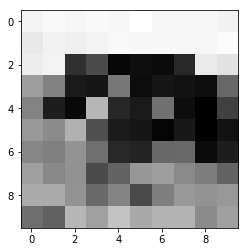

In [70]:
TARGET_IMAGE = 'E:/Users/Richard/Documents/One off mini projects/Typewriting/Typearter/fatdog2.png'
dog = Image.open(TARGET_IMAGE)
#dog.show()
smol_dog = dog.resize((10,10))
smol_dog = smol_dog.convert("L")

imshow(np.asarray(smol_dog), cmap='gray')
print(list(smol_dog.getdata()))
a=smol_dog.getdata()

w = 5
h = 5
c_y = 2
c_x = 2

for y in range(h):
    rows = range(c_y*y, c_y*(y+1))
    for x in range(w):
        columns = range(c_x*x, c_x*(x+1))
        chunk = [a[column + row*w*c_y] for row in rows for column in columns]